In [1]:
import numpy as np
import pandas as pd
import seaborn as sns #for plotting

#for data fetching
import xenaPython as xena

# for survival analysis
import lifelines
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

/Users/anne/anaconda/envs/psc/lib/python3.7/site-packages/xenaPython/__init__.py:110: FutureWarning: Possible nested set at position 7
  re.sub(r"^[^[]+[[]([^]]*)[]].*$", r"\1", query, flags=re.DOTALL))


# Fetch the data on TCGA (using XenaPython)

In [2]:
def get_codes(host, dataset, fields, data):
    "get codes for enumerations"
    codes = xena.field_codes(host, dataset, fields)
    codes_idx = dict([(x['name'], x['code'].split('\t')) for x in codes if x['code'] is not None])
    for i in range(len(fields)):
        if fields[i] in codes_idx:
            data[i] = [None if v == 'NaN' else codes_idx[fields[i]][int(v)] for v in data[i]]
    return data

def get_fields(host, dataset, samples, fields):
    "get field values"
    data = xena.dataset_fetch(host, dataset, samples, fields)
    return data

def get_fields_and_codes(host, dataset, samples, fields):
    "get fields and resolve codes"
    return get_codes( host, dataset, fields, get_fields( host, dataset, samples, fields))

### Gene expression data

In [73]:

hub = "https://gdc.xenahubs.net"
dataset = "TCGA-BRCA/Xena_Matrices/TCGA-BRCA.htseq_fpkm-uq.tsv" #database url was found on the hub website
samples = xena.dataset_samples (hub, dataset, None)
#wave genes
#genes =["NCKAP1","CYFIP2", "NCKAP1L", "WASF2", "ABI3", "WASF3", "ABI1", "ABI2", "CYFIP1", "WASF1", "BRK1"] #enter the genes of interest
#Arp2-3 genes
#genes = ["ACTR2", "ACTR3", "ARPC1A", "ARPC2", "ARPC3", "ARPC4", "ARPC5", "ACTR3B", "ARPC1B", "ARPC5L"]
#Arpin
genes = ["Arpin"]
fields = ["sampleID"]
expressions_0 = xena.dataset_gene_probe_avg(hub, dataset, samples, genes)

values = get_fields_and_codes(hub, dataset, samples, fields) # list of lists

genes_dict_for_df = dict(zip(fields, values)) #dict where we add the gene expression and the sample ids

In [74]:
for dico in expressions_0:
    label = "expression" + dico["gene"]
    scores = dico["scores"][0]
    assert len(scores) > 0
    genes_dict_for_df[label] = scores

### Survival data

In [75]:
dataset = "TCGA-BRCA/Xena_Matrices/TCGA-BRCA.survival.tsv"
fields = ['_TIME_TO_EVENT', "_EVENT", "sampleID"] #event is one if the patient has died or 0 if he was censored (lost...)
#TODO
# As in pancan, there are normal samples in tcga which should probably be removed. _sample_type will
# identify normals. _study will identify tcga vs. gtex vs. target.
values = get_fields_and_codes(hub, dataset, samples, fields) # list of lists
survival_dict_for_df = dict(zip(fields, values)) # index by phenotype

In [76]:
survival_dict_for_df["survival"] = survival_dict_for_df.pop("_TIME_TO_EVENT") 
survival_dict_for_df["event"] = survival_dict_for_df.pop("_EVENT")

### Phenotype data

In [77]:
dataset = "TCGA-BRCA/Xena_Matrices/TCGA-BRCA.GDC_phenotype.tsv"
fields = ['sample_type.samples', "sampleID"] 
values = get_fields_and_codes(hub, dataset, samples, fields) # list of lists
phenotype_dict_for_df = dict(zip(fields, values)) # index by phenotype

In [78]:
phenotype_dict_for_df["sample_type"] = phenotype_dict_for_df.pop('sample_type.samples')

Note : I don't know if it's useful to remove the patients whose tumor is not a "Primary Tumor", like advised by Xena. The goal is to remove duplicates but I can't find duplicates

### Merge data

In [79]:
df_genes = pd.DataFrame(data=genes_dict_for_df)
df_survival = pd.DataFrame(data=survival_dict_for_df)
#df_phenotype = pd.DataFrame(data=phenotype_dict_for_df)

df = pd.merge(df_genes, df_survival) # merge the survival and genes data according to sampleID
#df = pd.merge(df, df_phenotype) #merge also the phenotype data 
df = df.convert_objects(convert_numeric=True)
df = df[~pd.isna(df["survival"])][~pd.isna(df["event"])]
#df = df[df["sample_type"] == "Primary Tumor"] #keep only primary tumor to remove duplicate WARNING : check if name doesn't change if you use another dataset
#df = df.drop(['sampleID','sample_type'], axis=1) #remove identifier for analysis

df = df.drop('sampleID', axis=1) #remove identifier for analysis

/Users/anne/anaconda/envs/psc/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


In [80]:
df.head()

,expressionArpin,survival,event
0,17.38,4047,0
1,17.38,4005,0
2,16.67,1474,0
3,17.38,1448,0
4,17.71,348,0


   ## Export the data so we can use them with R

In [81]:
df.to_csv("data_base_Arpin")

# Analyse the data (using Lifelines)

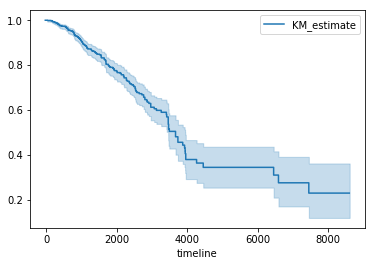

In [12]:
kmf = KaplanMeierFitter()
kmf.fit(df["survival"], df["event"]) #TODO : tell lifelines if the patient is censored or dead 
kmf.plot()

In [13]:
cph = CoxPHFitter()
cph.fit(df, duration_col='survival', event_col='event')


cph.print_summary() 

<lifelines.CoxPHFitter: fitted with 1203 observations, 1003 censored>
      duration col = 'survival'
         event col = 'event'
number of subjects = 1203
  number of events = 200
    log-likelihood = -1147.22
  time fit was run = 2019-01-24 17:14:54 UTC

---
                  coef  exp(coef)  se(coef)     z    p  log(p)  lower 0.95  upper 0.95   
expressionNCKAP1  0.23       1.26      0.18  1.30 0.20   -1.63       -0.12        0.58   
expressionARPIN   0.04       1.04      0.10  0.37 0.71   -0.34       -0.16        0.23   
expressionPICK1  -0.18       0.84      0.12 -1.52 0.13   -2.05       -0.41        0.05   
expressionWASF1   0.08       1.08      0.06  1.23 0.22   -1.52       -0.05        0.20   
expressionCYFIP1  0.28       1.32      0.19  1.48 0.14   -1.97       -0.09        0.64   
expressionABI1   -0.06       0.95      0.18 -0.31 0.76   -0.28       -0.41        0.30   
expressionBRK1    0.16       1.17      0.16  1.00 0.32   -1.15       -0.15        0.46   
---
Signif. codes:

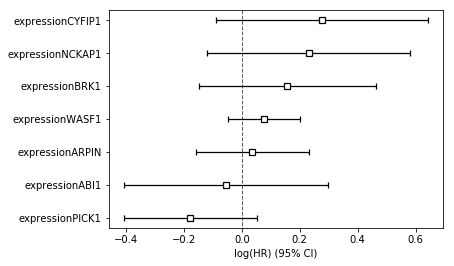

In [14]:
cph.plot()

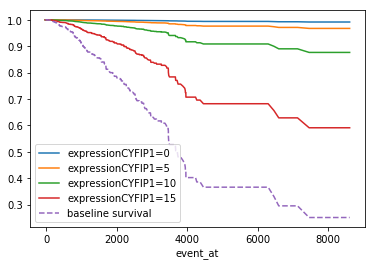

In [15]:
cph.plot_covariate_groups('expressionCYFIP1', [0, 5, 10, 15])

## The concordance and log-likelihood indicate that the model do not fit very well : let's check the assumptions for cox regression

In [20]:
# doesn't work so go to R

## TODO : do we have to remove tumors that are not Primary tumors from the list ? make the same transformation than Marc Lavielle, check assumption for Cox Regression, use other form of gene expression (RNAseq) to compare, use other datasets

Liens : 

objectifs en cours : https://docs.google.com/document/d/1A5wxgQ_ZPry4aRH1BsmdbmPJfJoIsy5sa-4P5RmWaTs/edit


dossier partagé : https://drive.google.com/drive/u/0/folders/1HotcSiF2BzDuzXMhKNX1p-7lI1U_3UQ9

rapport : https://www.overleaf.com/project/5c34f6b7f99dfe3f36bf3a55


### Generate data for report

In [67]:
df2 = pd.read_csv("data_for_report_arp23")

In [68]:
df2

,Unnamed: 0,coef,exp(coef),se(coef),z,Pr(>|z|)
0,expressionACTR2,-0.175868,0.838728,0.247238,-0.711333,0.476878
1,expressionACTR3,0.111441,1.117888,0.266382,0.418351,0.675691
2,expressionARPC1A,0.106827,1.112742,0.188127,0.567846,0.570140
3,expressionARPC2,0.166429,1.181080,0.237830,0.699781,0.484064
4,expressionARPC3,-0.220496,0.802121,0.177576,-1.241698,0.214348
5,expressionARPC4,-0.127033,0.880705,0.219331,-0.579181,0.562467
6,expressionARPC5,0.137872,1.147829,0.186991,0.737321,0.460927
7,expressionACTR3B,-0.200473,0.818344,0.100017,-2.004386,0.045029
8,expressionARPC1B,-0.246536,0.781503,0.114362,-2.155755,0.031103
9,expressionARPC5L,0.060699,1.062580,0.171384,0.354172,0.723210


In [69]:
df2 = df2[["Unnamed: 0", "coef", "Pr(>|z|)"]]

In [70]:
df2 = df2.rename(columns={"Unnamed: 0": "gene", "coef": "coefficient", "Pr(>|z|)" : "p-value"})

In [71]:
df2["gene"] = df2["gene"].apply(lambda x: x[10:])

In [72]:
%matplotlib
df2

Using matplotlib backend: MacOSX


,gene,coefficient,p-value
0,ACTR2,-0.175868,0.476878
1,ACTR3,0.111441,0.675691
2,ARPC1A,0.106827,0.570140
3,ARPC2,0.166429,0.484064
4,ARPC3,-0.220496,0.214348
5,ARPC4,-0.127033,0.562467
6,ARPC5,0.137872,0.460927
7,ACTR3B,-0.200473,0.045029
8,ARPC1B,-0.246536,0.031103
9,ARPC5L,0.060699,0.723210
